<a href="https://colab.research.google.com/github/Raanank10/UK_Used_Car_Data/blob/Raanan_30_05/100000_UK_Used_Car_Data_set_regression_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [439]:
# General tools
import numpy as np
import scipy as sp
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.metrics import pairwise_distances

# For the tree visualization
import pydot
from IPython.display import Image, display
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

# Global Parameters:

In [440]:
too_small_population = 30
this_year = 2021
sigma = 3

# Get the Data

In [441]:
url = 'https://raw.githubusercontent.com/Raanank10/UK_Used_Car_Data/main/toyota.csv'

df_Toyota = pd.read_csv(url)
df_Toyota.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [442]:
df_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [443]:
df_Toyota.shape

(6738, 9)

## Preprocessing - Cleaning

deleting duplicates and row counts under 30. We can`t assume anything based on pole of under 30 cars


In [444]:
unique_Toyota = df_Toyota.drop_duplicates(inplace=False)
unique_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6699 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6699 non-null   object 
 1   year          6699 non-null   int64  
 2   price         6699 non-null   int64  
 3   transmission  6699 non-null   object 
 4   mileage       6699 non-null   int64  
 5   fuelType      6699 non-null   object 
 6   tax           6699 non-null   int64  
 7   mpg           6699 non-null   float64
 8   engineSize    6699 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 523.4+ KB


In [445]:
unique_Toyota.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [446]:
for col in unique_Toyota.columns:
    if unique_Toyota[col].dtype == 'float64':
        std = unique_Toyota[col].std()
        ave = unique_Toyota[col].mean()
        unique_Toyota = unique_Toyota.loc[unique_Toyota[col].between\
                                          (ave - (sigma * std), ave + (sigma * std))] 
        print(f'Processing {col:10} --> {unique_Toyota.shape[0]:5} diamonds remain')

Processing mpg        -->  6658 diamonds remain
Processing engineSize -->  6580 diamonds remain


In [447]:
unique_Toyota.fuelType.value_counts()

Petrol    4042
Hybrid    2014
Diesel     426
Other       98
Name: fuelType, dtype: int64

In [448]:
unique_Toyota.transmission.value_counts()

Manual       3779
Automatic    2581
Semi-Auto     219
Other           1
Name: transmission, dtype: int64

In [449]:
unique_Toyota = unique_Toyota[unique_Toyota.groupby('transmission')\
                              .transmission.transform('count')>too_small_population].copy() 
unique_Toyota.transmission.value_counts()

Manual       3779
Automatic    2581
Semi-Auto     219
Name: transmission, dtype: int64

In [450]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('transmission')\
                              .transmission.transform('count')>too_small_population].copy() 
unique_Toyota.transmission.value_counts()

remove too_small_population=30


Manual       3779
Automatic    2581
Semi-Auto     219
Name: transmission, dtype: int64

In [451]:
unique_Toyota.model.value_counts()

 Yaris            2114
 Aygo             1937
 Auris             709
 C-HR              477
 RAV4              467
 Corolla           265
 Prius             202
 Verso             114
 Avensis           114
 GT86               73
 Hilux              66
 PROACE VERSO       15
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

In [452]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('model')\
                              .model.transform('count')>too_small_population].copy() 
unique_Toyota.model.value_counts()

remove too_small_population=30


 Yaris      2114
 Aygo       1937
 Auris       709
 C-HR        477
 RAV4        467
 Corolla     265
 Prius       202
 Verso       114
 Avensis     114
 GT86         73
 Hilux        66
Name: model, dtype: int64

In [453]:
unique_Toyota.model.unique()

array([' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ' Aygo', ' C-HR',
       ' Prius', ' Avensis', ' Verso', ' Hilux'], dtype=object)

Create new feature called  car _ group: Small, Family, SUV, Sport and Work

In [454]:
#unique_Toyota['car_group'] = 
def car_group_func(row):
    if row['model'] in [' Yaris',' Aygo']:
        return 'Small'
    elif row['model'] in [' Corolla',' Auris']:
        return 'Family'
    elif row['model'] in [' Prius',' Avensis']:
        return 'Family - High End'
    elif row['model'] in [' RAV4',' C-HR']:
        return 'SUV'
    elif row['model'] in [' Hilux',' Verso', ' GT86']:
        return 'Work and Sprot'
    else:
        return row['model'] #'Other'

unique_Toyota['car_group'] = unique_Toyota.apply(car_group_func, axis=1)

In [455]:
unique_Toyota.car_group.value_counts()
# group by:

Small                4051
Family                974
SUV                   944
Family - High End     316
Work and Sprot        253
Name: car_group, dtype: int64

In [456]:
unique_Toyota["car_age"] = this_year - unique_Toyota["year"]
unique_Toyota.drop('year',axis=1, inplace=True)

In [457]:
unique_Toyota.car_age.value_counts()

4     2004
2     1197
3     1006
5      982
6      509
7      343
8      195
1      109
9       38
10      34
12      26
14      20
13      18
11      18
16      11
15      10
18       6
17       5
19       4
20       1
22       1
21       1
Name: car_age, dtype: int64

In [458]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('car_age')\
                              .car_age.transform('count')>too_small_population].copy() 
unique_Toyota.car_age.value_counts()

remove too_small_population=30


4     2004
2     1197
3     1006
5      982
6      509
7      343
8      195
1      109
9       38
10      34
Name: car_age, dtype: int64

In [459]:
unique_Toyota.tax.value_counts() 

145    2004
0      1763
135     652
30      571
150     515
20      230
140     216
125     184
260      68
200      67
265      37
160      32
205      26
10       19
165      19
235       9
300       3
240       1
250       1
Name: tax, dtype: int64

In [460]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('tax')\
                              .tax.transform('count')>too_small_population].copy() 
unique_Toyota.tax.value_counts()

remove too_small_population=30


145    2004
0      1763
135     652
30      571
150     515
20      230
140     216
125     184
260      68
200      67
265      37
160      32
Name: tax, dtype: int64

In [461]:
unique_Toyota.engineSize.value_counts()

1.0    2006
1.5    1413
1.8    1199
1.3     563
2.0     344
1.2     298
2.5     236
1.6     149
2.4      60
1.4      36
2.2      35
Name: engineSize, dtype: int64

In [462]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('engineSize')\
                              .engineSize.transform('count')>too_small_population].copy() 
unique_Toyota.engineSize.value_counts()

remove too_small_population=30


1.0    2006
1.5    1413
1.8    1199
1.3     563
2.0     344
1.2     298
2.5     236
1.6     149
2.4      60
1.4      36
2.2      35
Name: engineSize, dtype: int64

In [463]:
unique_Toyota.mpg.value_counts()

69.0    674
68.9    472
56.5    461
47.9    408
74.3    362
58.9    347
58.0    283
78.5    214
72.4    199
57.7    174
67.3    174
76.3    173
55.0    170
78.0    168
86.0    158
60.1    135
57.6    129
47.1    121
55.4    117
70.6    110
67.0    108
85.6     92
65.7     74
39.2     72
94.1     68
52.3     67
36.2     66
43.5     57
49.6     55
41.5     50
62.8     49
80.7     48
76.4     47
61.4     43
66.0     43
51.4     41
40.4     32
65.6     27
53.3     25
42.2     22
33.2     21
54.3     21
53.0     21
46.3     20
42.8     20
68.8     17
64.2     17
51.1     14
44.8     10
48.7      8
32.8      7
39.8      6
38.7      6
34.5      5
45.6      4
51.3      2
44.1      2
83.1      1
37.7      1
50.4      1
Name: mpg, dtype: int64

In [464]:
# why mpg is so diffrent in same model?
#prg_model_mpg = unique_Toyota[unique_Toyota['model']== ' Yaris'].groupby(['model', 'mpg']).size().head(50)
prg_model_mpg = unique_Toyota.groupby(['mpg','model']).size().head(50).sort_values(ascending=False)
print(prg_model_mpg)

mpg   model   
47.9   Yaris      362
39.2   Corolla     72
47.1   Yaris       60
49.6   RAV4        47
47.1   C-HR        41
52.3   Yaris       39
36.2   GT86        39
47.9   C-HR        36
43.5   RAV4        35
40.4   Hilux       32
51.4   Yaris       28
52.3   Auris       27
36.2   Hilux       27
41.5   Verso       27
       C-HR        23
53.0   RAV4        21
33.2   GT86        21
42.2   RAV4        20
42.8   Verso       18
43.5   Verso       17
47.1   Avensis     15
46.3   Auris       15
51.1   RAV4        14
51.4   Auris       13
44.8   C-HR        10
47.9   Auris       10
32.8   GT86         7
38.7   Hilux        6
39.8   GT86         5
34.5   C-HR         5
46.3   Avensis      5
49.6   Yaris        5
45.6   Avensis      4
48.7   Yaris        4
47.1   RAV4         4
48.7   Auris        3
49.6   Auris        3
43.5   Avensis      3
42.8   Auris        2
42.2   Avensis      2
44.1   Avensis      2
51.3   Auris        2
43.5   Yaris        2
53.3   Auris        2
48.7   RAV4      

In [465]:
print(f'remove too_small_population={too_small_population}')
unique_Toyota = unique_Toyota[unique_Toyota.groupby('mpg')\
                              .mpg.transform('count')>too_small_population].copy() 
unique_Toyota.mpg.value_counts()

remove too_small_population=30


69.0    674
68.9    472
56.5    461
47.9    408
74.3    362
58.9    347
58.0    283
78.5    214
72.4    199
67.3    174
57.7    174
76.3    173
55.0    170
78.0    168
86.0    158
60.1    135
57.6    129
47.1    121
55.4    117
70.6    110
67.0    108
85.6     92
65.7     74
39.2     72
94.1     68
52.3     67
36.2     66
43.5     57
49.6     55
41.5     50
62.8     49
80.7     48
76.4     47
66.0     43
61.4     43
51.4     41
40.4     32
Name: mpg, dtype: int64

In [466]:
unique_Toyota['mpg_group'] = ((unique_Toyota['mpg'] /10).round(0))*10 #.value_counts()

In [467]:
unique_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6061 entries, 0 to 6632
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6061 non-null   object 
 1   price         6061 non-null   int64  
 2   transmission  6061 non-null   object 
 3   mileage       6061 non-null   int64  
 4   fuelType      6061 non-null   object 
 5   tax           6061 non-null   int64  
 6   mpg           6061 non-null   float64
 7   engineSize    6061 non-null   float64
 8   car_group     6061 non-null   object 
 9   car_age       6061 non-null   int64  
 10  mpg_group     6061 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 568.2+ KB


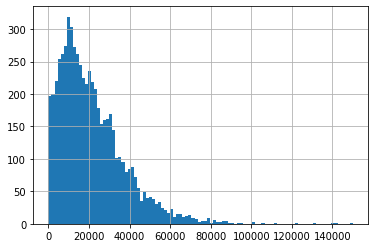

In [468]:
unique_Toyota.mileage.hist(bins=100)

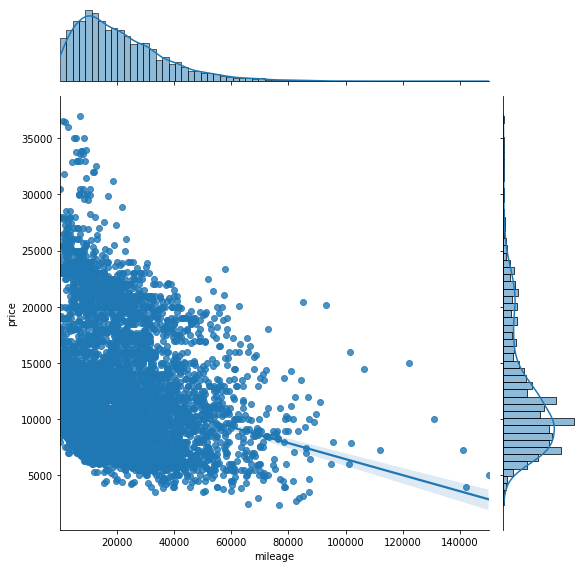

In [469]:
sns.jointplot(x='mileage', y='price', data = unique_Toyota, kind='reg', height=8)

In [470]:
unique_Toyota.describe()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group
count,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000
mean,12057.604026,21469.472859,88.066326,63.990216,1.426382,4.045537,65.319254
std,5220.098860,16219.306943,70.142050,11.535132,0.396176,1.616511,11.318282
min,2395.000000,2.000000,0.000000,36.200000,1.000000,1.000000,40.000000
25%,8295.000000,9500.000000,0.000000,56.500000,1.000000,3.000000,60.000000
50%,10500.000000,18000.000000,135.000000,67.000000,1.500000,4.000000,70.000000
75%,14245.000000,29944.000000,145.000000,72.400000,1.800000,5.000000,70.000000
max,36990.000000,150000.000000,265.000000,94.100000,2.500000,10.000000,90.000000


## Preprocessing

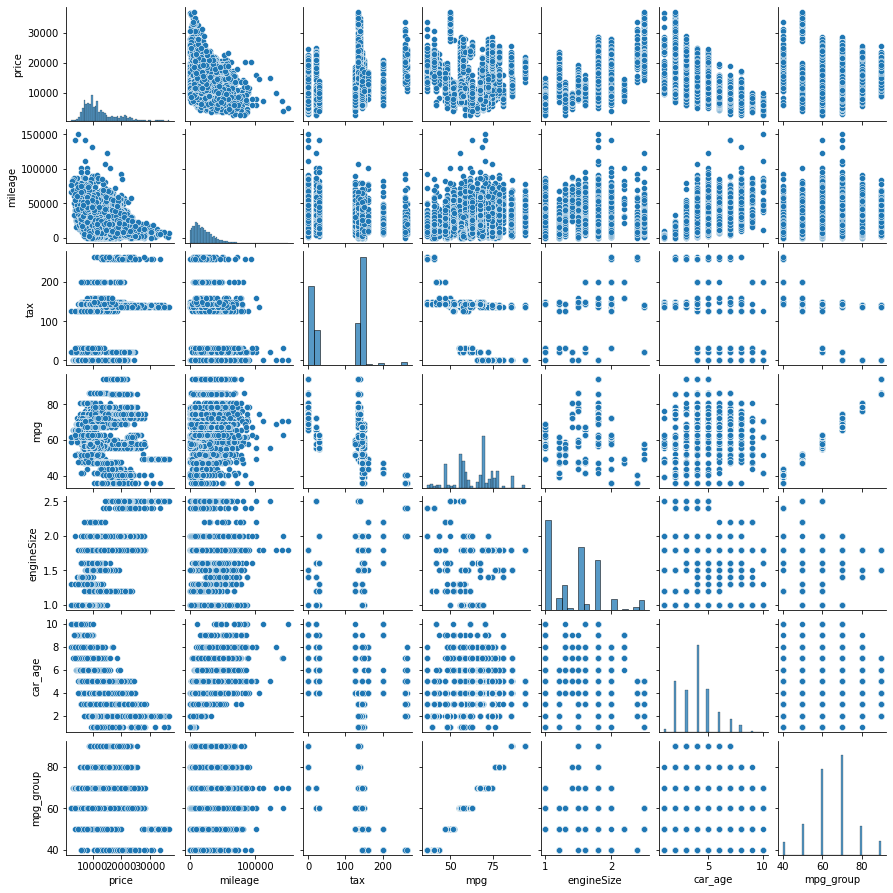

In [471]:
unique_Toyota_num = unique_Toyota.select_dtypes(include=np.number)
sns.pairplot(unique_Toyota_num ,height=1.8)

In [472]:
# unique_Toyota_num = unique_Toyota.select_dtypes(include=np.number)
# sns.pairplot(unique_Toyota_num, hue= 'price' ,height=1.8)

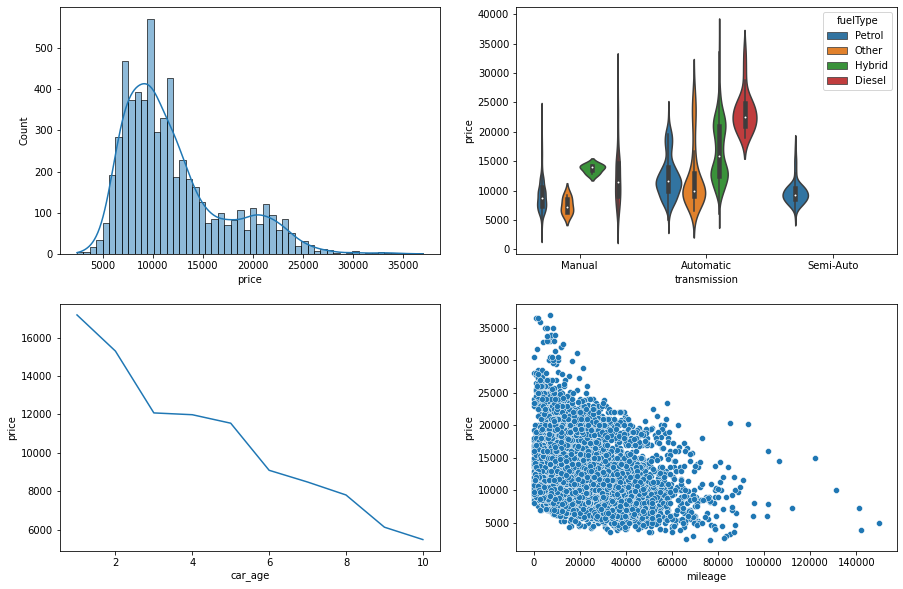

In [473]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.histplot(unique_Toyota.price, kde=True, ax=ax[0,0])
sns.violinplot(x='transmission',  y='price', data = unique_Toyota, hue='fuelType', ax=ax[0,1])
sns.lineplot(x='car_age', y='price', data = unique_Toyota, ci=None, ax=ax[1,0])
sns.scatterplot(x='mileage', y='price', data = unique_Toyota, ax=ax[1,1]);

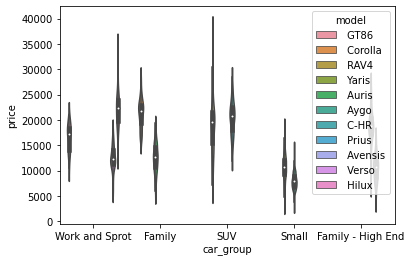

In [474]:
sns.violinplot(x='car_group',  y='price', data = unique_Toyota, hue='model', legend='brief') #,ax=ax[0,1])


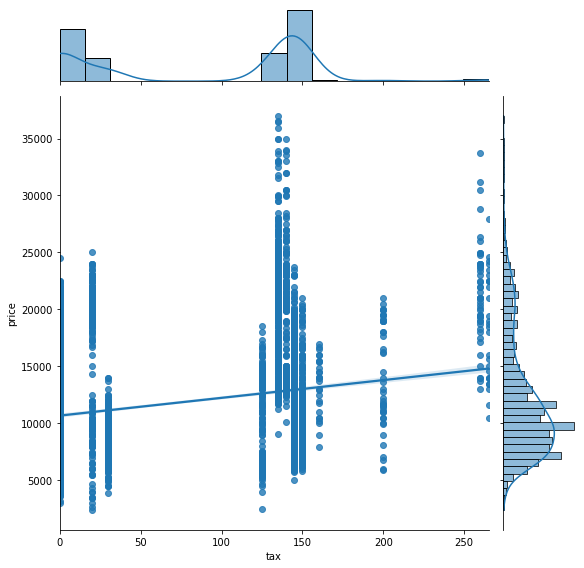

In [475]:
sns.jointplot(x='tax', y='price', data=unique_Toyota, kind='reg', height=8)

Text(0.5, 1.0, 'Toyota cars by Model')

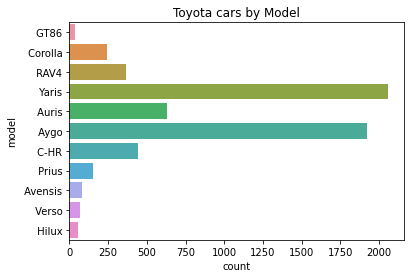

In [476]:
sns.countplot(y = "model", data=unique_Toyota).set_title("Toyota cars by Model")

In [477]:
unique_Toyota.corr()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group
price,1.000000,-0.221875,0.209423,0.015671,0.762581,-0.381670,-0.048337
mileage,-0.221875,1.000000,-0.408858,0.201291,0.185438,0.657436,0.178730
tax,0.209423,-0.408858,1.000000,-0.488989,0.006717,-0.607804,-0.497335
mpg,0.015671,0.201291,-0.488989,1.000000,0.009951,0.250971,0.979037
engineSize,0.762581,0.185438,0.006717,0.009951,1.000000,0.029534,-0.042268
car_age,-0.381670,0.657436,-0.607804,0.250971,0.029534,1.000000,0.237673
mpg_group,-0.048337,0.178730,-0.497335,0.979037,-0.042268,0.237673,1.000000


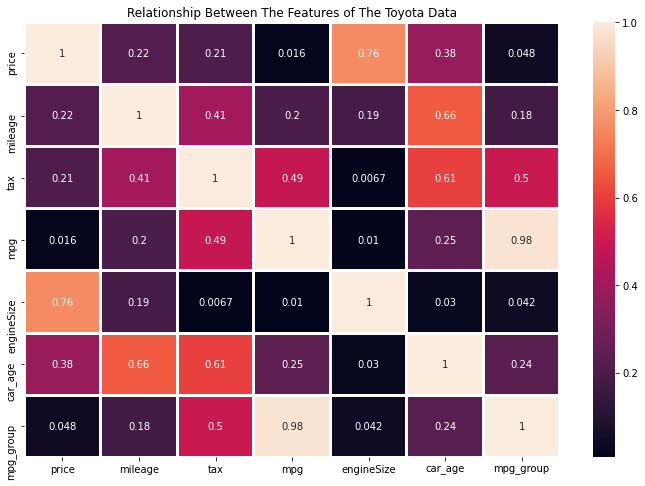

In [478]:
plt.figure(figsize=(12,8))
plt.title("Relationship Between The Features of The Toyota Data")
sns.heatmap(unique_Toyota.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

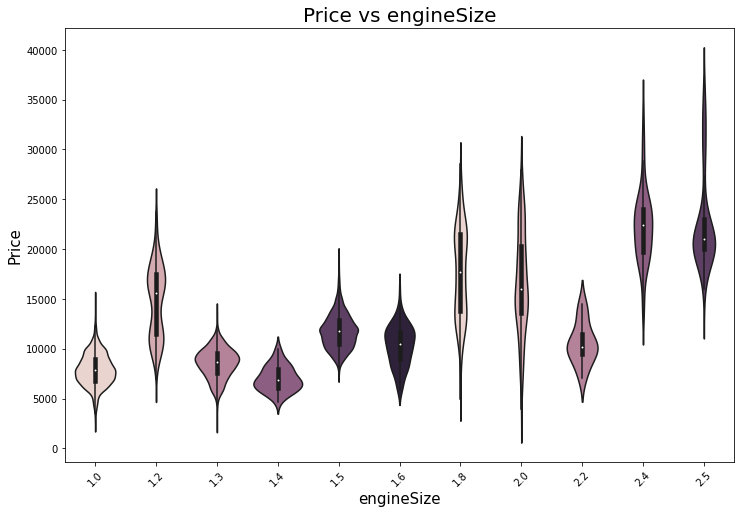

In [479]:
plt.figure(figsize=(12,8))

sns.violinplot(x= unique_Toyota.engineSize, y = unique_Toyota.price, palette=sns.cubehelix_palette())

plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel("Price", fontsize = 15)
plt.xlabel("engineSize", fontsize = 15)
plt.title("Price vs engineSize", fontsize = 20)
plt.show()

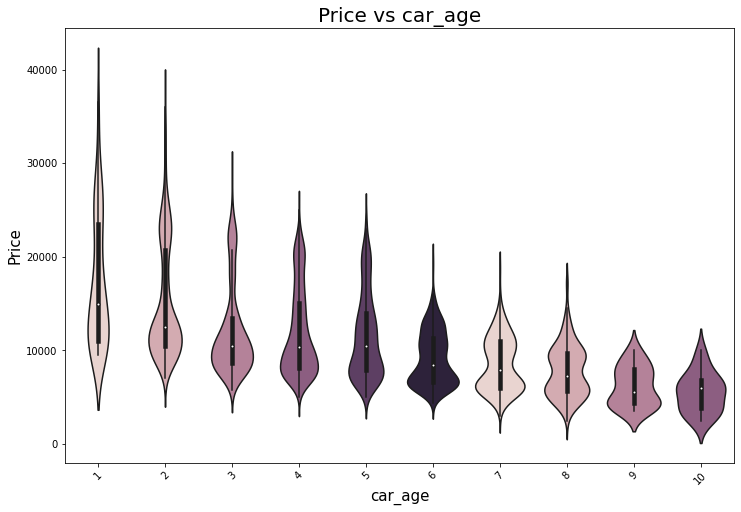

In [480]:
plt.figure(figsize=(12,8))

sns.violinplot(x= unique_Toyota.car_age, y = unique_Toyota.price, palette=sns.cubehelix_palette())

plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel("Price", fontsize = 15)
plt.xlabel("car_age", fontsize = 15)
plt.title("Price vs car_age", fontsize = 20)
plt.show()

[Text(0.5, 1.0, 'Mileage per price')]

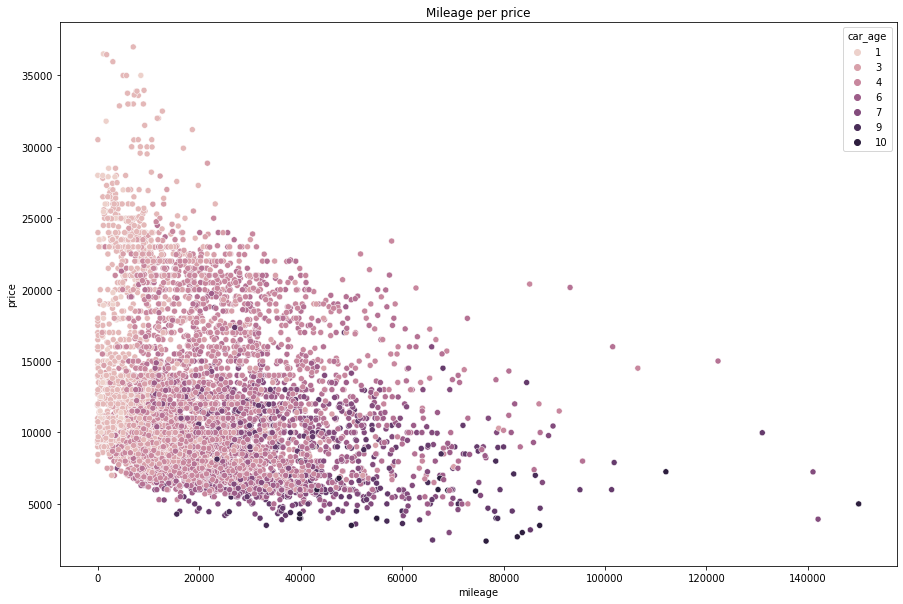

In [481]:
plt.figure(figsize=(15,10)) 
sns.scatterplot(data = unique_Toyota, x= "mileage", y="price", hue = "car_age")\
.set(title = "Mileage per price")

## Data Preparation - Splitting the Data

In [482]:
unique_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6061 entries, 0 to 6632
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6061 non-null   object 
 1   price         6061 non-null   int64  
 2   transmission  6061 non-null   object 
 3   mileage       6061 non-null   int64  
 4   fuelType      6061 non-null   object 
 5   tax           6061 non-null   int64  
 6   mpg           6061 non-null   float64
 7   engineSize    6061 non-null   float64
 8   car_group     6061 non-null   object 
 9   car_age       6061 non-null   int64  
 10  mpg_group     6061 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 728.2+ KB


In [483]:
dummies_Toyota = pd.get_dummies(data = unique_Toyota,columns=["model","transmission","fuelType","car_group"])
dummies_Toyota.head()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot
0,16000,24089,265,36.2,2.0,5,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,15995,18615,145,36.2,2.0,4,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,13998,27469,265,36.2,2.0,6,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,18998,14736,150,36.2,2.0,4,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,17498,36284,145,36.2,2.0,4,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


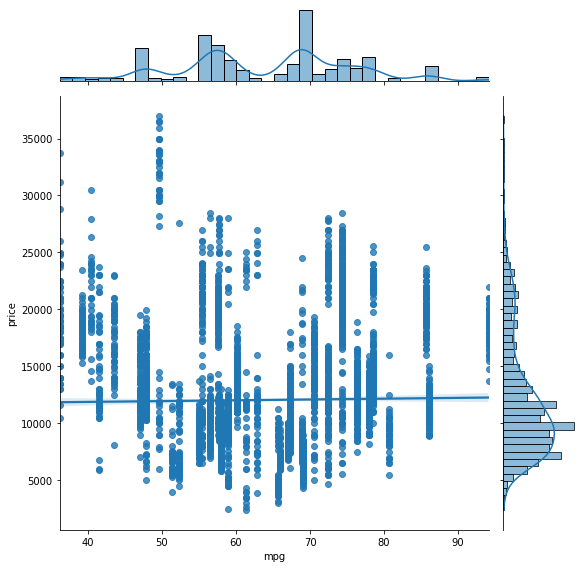

In [484]:
sns.jointplot(x='mpg', y='price', data=dummies_Toyota, kind='reg', height=8)

In [485]:
X = dummies_Toyota.drop('price', axis=1)
y = dummies_Toyota.price

In [486]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=124124)

In [487]:
X_train.head(10)

,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot
3128,21138,20,67.3,1.6,4,70.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
4388,5691,145,56.5,1.0,3,60.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3102,36645,0,72.4,1.8,7,70.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1880,16448,0,66.0,1.0,4,70.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3120,52368,0,72.4,1.8,6,70.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
5661,5810,135,74.3,1.8,3,70.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
777,20431,20,57.6,2.5,4,60.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1591,39675,125,51.4,1.3,8,50.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2053,52667,0,66.0,1.0,5,70.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2777,16089,0,86.0,1.5,4,90.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0


In [488]:
y_train.head(10)

3128     9998
4388     9799
3102    11000
1880     8250
3120    10998
5661    23990
777     22495
1591     5750
2053     6997
2777    12290
Name: price, dtype: int64

In [489]:
dummies_Toyota.describe()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot
count,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000,6061.000000
mean,12057.604026,21469.472859,88.066326,63.990216,1.426382,4.045537,65.319254,0.103943,0.013694,0.316779,0.073585,0.039597,0.006435,0.009734,0.025408,0.060056,0.011219,0.339548,0.381290,0.589012,0.029698,0.052962,0.309355,0.014024,0.623659,0.143541,0.039102,0.133641,0.656327,0.027388
std,5220.098860,16219.306943,70.142050,11.535132,0.396176,1.616511,11.318282,0.305212,0.116227,0.465259,0.261116,0.195028,0.079964,0.098190,0.157375,0.237610,0.105334,0.473595,0.485744,0.492054,0.169767,0.223975,0.462266,0.117600,0.484507,0.350652,0.193855,0.340295,0.474973,0.163225
min,2395.000000,2.000000,0.000000,36.200000,1.000000,1.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8295.000000,9500.000000,0.000000,56.500000,1.000000,3.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10500.000000,18000.000000,135.000000,67.000000,1.500000,4.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,14245.000000,29944.000000,145.000000,72.400000,1.800000,5.000000,70.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,36990.000000,150000.000000,265.000000,94.100000,2.500000,10.000000,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


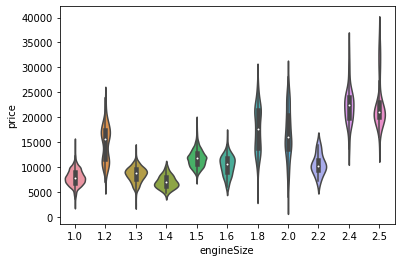

In [490]:
ax = sns.violinplot(x="engineSize", y="price", data=dummies_Toyota)

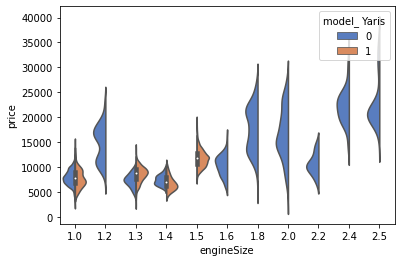

In [491]:
ax = sns.violinplot(x="engineSize", y="price", data=dummies_Toyota , hue="model_ Yaris", palette="muted", split=True)

# Different Models 

##  Linear Regression

#### Fitting the Model

In [492]:
lin_model_1 = LinearRegression().fit(X_train, y_train)

In [493]:
list(zip(X_train.columns, lin_model_1.coef_))

[('mileage', -0.053919667985713),
 ('tax', -2.5458039717835854),
 ('mpg', 21.387624359682917),
 ('engineSize', 2845.795957382954),
 ('car_age', -793.6595232440538),
 ('mpg_group', -60.034962737685625),
 ('model_ Auris', -2501.1433959927936),
 ('model_ Avensis', -1714.2900627647036),
 ('model_ Aygo', -1866.1940770080964),
 ('model_ C-HR', 1077.4058768799332),
 ('model_ Corolla', 2399.673555836225),
 ('model_ GT86', 255.38124563633687),
 ('model_ Hilux', 4162.730954534479),
 ('model_ Prius', 1784.9143493542424),
 ('model_ RAV4', 420.1715803319583),
 ('model_ Verso', -2970.4711950166525),
 ('model_ Yaris', -1048.178831790928),
 ('transmission_Automatic', 490.3762586256683),
 ('transmission_Manual', -848.4993745260213),
 ('transmission_Semi-Auto', 358.123115900352),
 ('fuelType_Diesel', -1559.108575402186),
 ('fuelType_Hybrid', 1725.982360815625),
 ('fuelType_Other', 430.3414918222691),
 ('fuelType_Petrol', -597.2152772357081),
 ('car_group_Family', -101.46984015657182),
 ('car_group_Famil

In [494]:
sorted(list(zip(X_train.columns, lin_model_1.coef_)), key = lambda x: x[1])

[('model_ Verso', -2970.4711950166525),
 ('car_group_Small', -2914.372908799023),
 ('model_ Auris', -2501.1433959927936),
 ('model_ Aygo', -1866.1940770080964),
 ('model_ Avensis', -1714.2900627647036),
 ('fuelType_Diesel', -1559.108575402186),
 ('model_ Yaris', -1048.178831790928),
 ('transmission_Manual', -848.4993745260213),
 ('car_age', -793.6595232440538),
 ('fuelType_Petrol', -597.2152772357081),
 ('car_group_Family', -101.46984015657182),
 ('mpg_group', -60.034962737685625),
 ('tax', -2.5458039717835854),
 ('mileage', -0.053919667985713),
 ('mpg', 21.387624359682917),
 ('car_group_Family - High End', 70.62428658953834),
 ('model_ GT86', 255.38124563633687),
 ('transmission_Semi-Auto', 358.123115900352),
 ('model_ RAV4', 420.1715803319583),
 ('fuelType_Other', 430.3414918222691),
 ('transmission_Automatic', 490.3762586256683),
 ('model_ C-HR', 1077.4058768799332),
 ('car_group_Work and Sprot', 1447.6410051541602),
 ('car_group_SUV', 1497.5774572118935),
 ('fuelType_Hybrid', 1725.

#### Predicting with the Model

In [495]:
y_train_pred = lin_model_1.predict(X_train)

In [496]:
print(y_train_pred, '\n', y_train.values)

[10432.72954494 10393.50843189 12568.73740827 ... 10229.70763774
  8806.1936853  21386.27631217] 
 [ 9998  9799 11000 ... 10290 11000 21381]


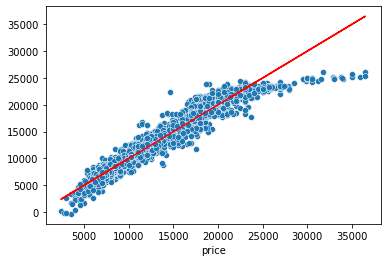

In [497]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [498]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_train[-150:]))), y=y_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_train_pred[-150:]))), y=y_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

In [499]:
print(X.columns,"\n")

formula = 'Weight = ' + f'{lin_model_1.intercept_:.3f}'
for coef, feature in zip(lin_model_1.coef_, X.columns[:4]):
    formula += f' {coef:+.5f}*{feature}'

print(formula)

Index(['mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'mpg_group',
       'model_ Auris', 'model_ Avensis', 'model_ Aygo', 'model_ C-HR',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ Prius',
       'model_ RAV4', 'model_ Verso', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol',
       'car_group_Family', 'car_group_Family - High End', 'car_group_SUV',
       'car_group_Small', 'car_group_Work and Sprot'],
      dtype='object') 

Weight = 18018.046 -0.05392*mileage -2.54580*tax +21.38762*mpg +2845.79596*engineSize


In [500]:
mse(y_train, y_train_pred)**0.5

1300.058625743264

In [501]:
print('r2_score: ', round(r2_score(y_train, y_train_pred)*100, 2))

r2_score:  93.79


### Mileage per age_car hyperparameter

In [502]:
len(dummies_Toyota.mileage.value_counts()) 

5246

In [503]:
dummies_Toyota['mileage_per_year'] = ((dummies_Toyota['mileage'] /\
                                      dummies_Toyota['car_age']).round(0))*10 #.value_counts()

In [504]:
dummies_Toyota.mileage_per_year.value_counts()

25000.0    26
40000.0    23
50000.0    21
60000.0    17
5000.0     17
           ..
84940.0     1
22720.0     1
57380.0     1
96340.0     1
42370.0     1
Name: mileage_per_year, Length: 4178, dtype: int64

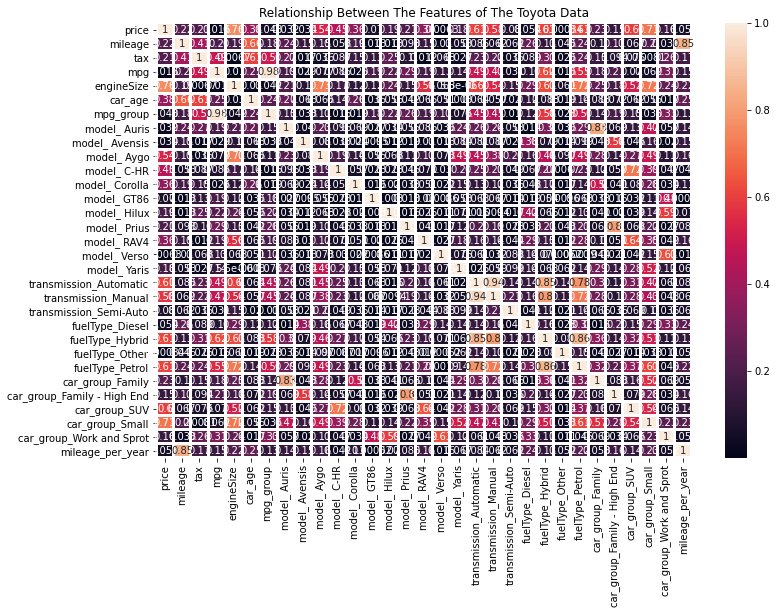

In [505]:
plt.figure(figsize=(12,8))
plt.title("Relationship Between The Features of The Toyota Data")
sns.heatmap(dummies_Toyota.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [506]:
X_hyper = dummies_Toyota.drop('price', axis=1)
y_hyper = dummies_Toyota.price

In [507]:
X_hyper_train, X_hyper_test, y_hyper_train, y_hyper_test = split(X_hyper, y_hyper, test_size=0.3, random_state=124124)

In [508]:
lin_model_hyper = LinearRegression().fit(X_hyper_train, y_hyper_train)

In [509]:
sorted(list(zip(X_train.columns, lin_model_hyper.coef_)), key = lambda x:x[1])

[('model_ Verso', -3048.0805985641164),
 ('car_group_Small', -3026.296745015159),
 ('model_ Auris', -2498.2657434966823),
 ('model_ Aygo', -1987.0855691106865),
 ('fuelType_Diesel', -1679.2149663770515),
 ('model_ Avensis', -1604.1796773169697),
 ('model_ Yaris', -1039.2111758589072),
 ('car_age', -939.2095403736936),
 ('transmission_Manual', -846.638922047364),
 ('fuelType_Petrol', -490.67750824500564),
 ('car_group_Family', -166.38876811055584),
 ('mpg_group', -60.02628437278976),
 ('tax', -2.5477148169951356),
 ('mileage', -0.024446477896616293),
 ('mpg', 30.263295932299474),
 ('car_group_Family - High End', 39.04635646428374),
 ('model_ GT86', 212.95420264424249),
 ('transmission_Semi-Auto', 378.1894225317244),
 ('transmission_Automatic', 468.44949954092607),
 ('fuelType_Other', 485.6033470074792),
 ('model_ RAV4', 536.542350280584),
 ('model_ C-HR', 1008.0883566344532),
 ('car_group_SUV', 1544.630706902404),
 ('car_group_Work and Sprot', 1609.0084497333855),
 ('model_ Prius', 1643

In [510]:
y_hyper_train_pred = lin_model_hyper.predict(X_hyper_train)

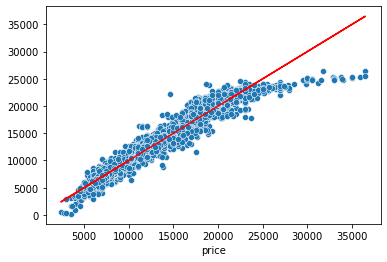

In [511]:
ax = sns.scatterplot(x=y_hyper_train, y=y_hyper_train_pred)
ax.plot(y_hyper_train, y_hyper_train, 'r')

In [512]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_hyper_train[-150:]))), y=y_hyper_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_hyper_train_pred[-150:]))), y=y_hyper_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

In [513]:
print(X_hyper.columns,"\n")

formula = 'Weight = ' + f'{lin_model_hyper.intercept_:.3f}'
for coef, feature in zip(lin_model_hyper.coef_, X_hyper.columns[:4]):
    formula += f' {coef:+.5f}*{feature}'

print(formula)

Index(['mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'mpg_group',
       'model_ Auris', 'model_ Avensis', 'model_ Aygo', 'model_ C-HR',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ Prius',
       'model_ RAV4', 'model_ Verso', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol',
       'car_group_Family', 'car_group_Family - High End', 'car_group_SUV',
       'car_group_Small', 'car_group_Work and Sprot', 'mileage_per_year'],
      dtype='object') 

Weight = 18269.700 -0.02445*mileage -2.54771*tax +30.26330*mpg +2764.88791*engineSize


In [514]:
mse(y_hyper_train, y_hyper_train_pred)**0.5

1293.5159962317746

In [515]:
print('r2_score: ', round(r2_score(y_hyper_train, y_hyper_train_pred)*100, 2))

r2_score:  93.85


## Linear Model for Yaris and Aygo

### Filtering for Yaris Only

In [516]:
model_Yaris = dummies_Toyota.loc[dummies_Toyota['model_ Yaris'] == 1]
model_Yaris.head()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
813,14000,6821,150,47.9,1.5,2,50.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,34100.0
814,10750,14000,145,58.9,1.5,3,60.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,46670.0
815,11500,31911,0,78.0,1.5,5,80.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,63820.0
816,8500,72053,0,76.3,1.5,7,80.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,102930.0
817,8750,32594,150,58.9,1.5,4,60.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,81480.0


In [517]:
X_yaris = model_Yaris.drop('price', axis=1)
y_yaris = model_Yaris.price

### Spliting the Data



In [518]:
X_yaris_train, X_yaris_test, y_yaris_train, y_yaris_test = split(X_yaris, y_yaris, test_size=0.3, random_state=124124)

### Fitting the Model

In [519]:
lin_model_Yaris = LinearRegression().fit(X_yaris_train, y_yaris_train)

### Predicting with the Model

In [520]:
y_yaris_train_pred = lin_model_Yaris.predict(X_yaris_train)

### evaluating Yaris the model

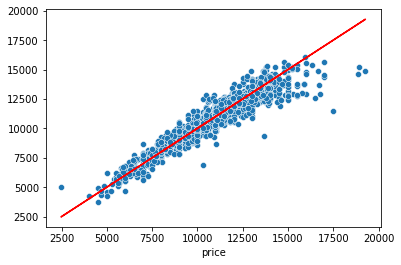

In [521]:
ax = sns.scatterplot(x=y_yaris_train, y=y_yaris_train_pred)
ax.plot(y_yaris_train, y_yaris_train, 'r')

In [522]:
print(X.columns,"\n")

formula = 'Weight = ' + f'{lin_model_Yaris.intercept_:.3f}'
for coef, feature in zip(lin_model_Yaris.coef_, X_yaris.columns[:4]):
    formula += f' {coef:+.5f}*{feature}'

print(formula)

Index(['mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'mpg_group',
       'model_ Auris', 'model_ Avensis', 'model_ Aygo', 'model_ C-HR',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ Prius',
       'model_ RAV4', 'model_ Verso', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol',
       'car_group_Family', 'car_group_Family - High End', 'car_group_SUV',
       'car_group_Small', 'car_group_Work and Sprot'],
      dtype='object') 

Weight = 16061.187 -0.01291*mileage -0.34889*tax -107.24673*mpg +2472.77103*engineSize


In [523]:
mse(y_yaris_train, y_yaris_train_pred)**0.5

795.4623417624616

In [524]:
y_yaris_train.describe()

count     1440.000000
mean     10712.540972
std       2335.423487
min       2470.000000
25%       9221.250000
50%      10790.000000
75%      12259.250000
max      19276.000000
Name: price, dtype: float64

In [525]:
y_yaris_train.mean()

10712.540972222223

### Remove outlier

In [526]:
model_Yaris.price.mean()

10718.067541302235

In [527]:
model_Yaris.describe()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.0,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.0,2058.0,2058.0,2058.0,2058.0,2058.000000
mean,10718.067541,20266.863946,85.417881,61.766715,1.426385,4.063654,64.135083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.364431,0.629252,0.006317,0.010204,0.268707,0.003887,0.717201,0.0,0.0,0.0,1.0,0.0,47291.520894
std,2305.015680,14777.882067,64.493806,12.113741,0.123231,1.658299,12.521454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481387,0.483123,0.079246,0.100523,0.443395,0.062242,0.450469,0.0,0.0,0.0,0.0,0.0,27159.241479
min,2470.000000,2.000000,0.000000,43.500000,1.000000,1.000000,40.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,20.000000
25%,9250.000000,9141.000000,30.000000,55.000000,1.300000,3.000000,60.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,28720.000000
50%,10758.000000,16987.000000,135.000000,58.000000,1.500000,4.000000,60.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,43865.000000
75%,12198.750000,28292.250000,145.000000,76.300000,1.500000,5.000000,80.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,61325.000000
max,19276.000000,87210.000000,160.000000,86.000000,1.500000,10.000000,90.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,263440.000000


In [528]:
q_low = model_Yaris["price"].quantile(0.05)
q_hi  = model_Yaris["price"].quantile(0.95)

print(f'prine mean={model_Yaris.price.mean()}, q_low= {q_low}, q_hi={q_hi}')

model_Yaris_no_outliers = model_Yaris[(model_Yaris["price"] < q_hi) & (model_Yaris["price"] > q_low)]


prine mean=10718.067541302235, q_low= 6669.900000000001, q_hi=14306.09999999999


In [529]:
model_Yaris_no_outliers.describe()
model_Yaris_no_outliers.price.count()

1852

RMSE = 671.1652374257133 ,prine mean= 10722.917926565875


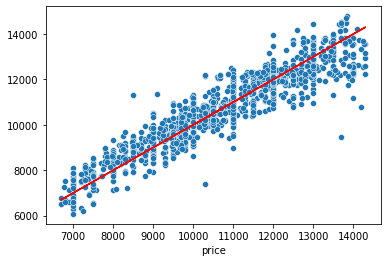

In [530]:
X_yaris_nout = model_Yaris_no_outliers.drop('price', axis=1)
y_yaris_nout = model_Yaris_no_outliers.price

X_yaris_nout_train, X_yaris_nout_test, y_yaris_nout_train, y_yaris_nout_test \
= split(X_yaris_nout, y_yaris_nout, test_size=0.3, random_state=124124)

lin_model_Yaris_no_outliers = LinearRegression().fit(X_yaris_nout_train, y_yaris_nout_train)

y_yaris_nout_train_pred = lin_model_Yaris_no_outliers.predict(X_yaris_nout_train)

print(f'RMSE = {mse(y_yaris_nout_train, y_yaris_nout_train_pred)**0.5} ,prine mean= {model_Yaris_no_outliers.price.mean()}')

ax = sns.scatterplot(x=y_yaris_nout_train, y=y_yaris_nout_train_pred)
ax.plot(y_yaris_nout_train, y_yaris_nout_train, 'r')

###  Filtering for Aygo *Only*

In [531]:
model_Aygo = dummies_Toyota.loc[dummies_Toyota['model_ Aygo'] == 1]
model_Aygo.head()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
3647,9250,4414,150,68.9,1.0,4,70.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,11040.0
3648,7100,32351,0,68.9,1.0,4,70.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,80880.0
3649,6500,26193,0,69.0,1.0,5,70.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,52390.0
3650,7650,12134,0,68.9,1.0,4,70.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,30340.0
3651,6999,21123,0,69.0,1.0,5,70.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,42250.0


In [579]:
X_Aygo = model_Aygo.drop('price', axis=1)
y_Aygo = model_Aygo.price

### Spliting the Data

In [580]:
X_Aygo_train, X_Aygo_test, y_Aygo_train, y_Aygo_test = \
split(X_Aygo, y_Aygo, test_size=0.3, random_state=124124)

### Fitting the Model

In [581]:
lin_model_Aygo = LinearRegression().fit(X_Aygo_train, y_Aygo_train)

### Predicting with the Model

In [582]:
y_Aygo_train_pred = lin_model_Aygo.predict(X_Aygo_train)

### evaluating Aygo the model

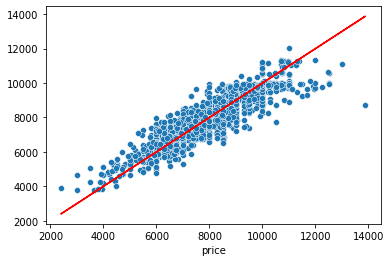

In [583]:
ax = sns.scatterplot(x=y_Aygo_train, y=y_Aygo_train_pred)
ax.plot(y_Aygo_train, y_Aygo_train, 'r')

In [584]:
print(X.columns,"\n")

formula = 'Weight = ' + f'{lin_model_Aygo.intercept_:.3f}'
for coef, feature in zip(lin_model_Aygo.coef_, X_Aygo.columns[:4]):
    formula += f' {coef:+.5f}*{feature}'

print(formula)

Index(['mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'mpg_group',
       'model_ Auris', 'model_ Avensis', 'model_ Aygo', 'model_ C-HR',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ Prius',
       'model_ RAV4', 'model_ Verso', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol',
       'car_group_Family', 'car_group_Family - High End', 'car_group_SUV',
       'car_group_Small', 'car_group_Work and Sprot', 'mileage_per_year'],
      dtype='object') 

Weight = 16142.571 +0.00135*mileage +0.41005*tax +40.40882*mpg -0.00000*engineSize


In [586]:
mse(y_Aygo_train, y_Aygo_train_pred)**0.5

722.35930098013

In [588]:
y_Aygo_train.describe()

count     1344.000000
mean      7916.854167
std       1597.300235
min       2395.000000
25%       6800.000000
50%       7850.000000
75%       8995.000000
max      13881.000000
Name: price, dtype: float64

In [589]:
y_Aygo_train.mean()

7916.854166666667

### Remove outlier

In [590]:
model_Aygo.price.mean()

7925.9828125

In [591]:
model_Aygo.describe()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.0,1920.000000,1920.000000,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.0,1920.000000,1920.000000,1920.000000,1920.0,1920.0,1920.000000,1920.000000,1920.0,1920.0,1920.0,1920.0,1920.0,1920.000000
mean,7925.982813,17795.442708,91.752604,65.295156,1.0,3.891667,67.177083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057292,0.862500,0.080208,0.0,0.0,0.030729,0.969271,0.0,0.0,0.0,1.0,0.0,42919.796875
std,1606.854162,13360.021644,70.511706,5.316226,0.0,1.538030,4.502318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232460,0.344464,0.271686,0.0,0.0,0.172628,0.172628,0.0,0.0,0.0,0.0,0.0,25782.578667
min,2395.000000,3.000000,0.000000,55.400000,1.0,1.000000,60.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,20.000000
25%,6874.500000,8009.000000,0.000000,57.700000,1.0,3.000000,60.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,25000.000000
50%,7891.000000,14993.000000,145.000000,68.900000,1.0,4.000000,70.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,39735.000000
75%,8995.000000,24606.250000,145.000000,69.000000,1.0,5.000000,70.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,56132.500000
max,15000.000000,87125.000000,150.000000,69.000000,1.0,10.000000,70.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,182420.000000


In [592]:
q_low = model_Aygo["price"].quantile(0.05)
q_hi  = model_Aygo["price"].quantile(0.95)

print(f'prine mean={model_Aygo.price.mean()}, q_low= {q_low}, q_hi={q_hi}')

model_Aygo_no_outliers = model_Aygo[(model_Aygo["price"] < q_hi) & (model_Aygo["price"] > q_low)]


prine mean=7925.9828125, q_low= 5498.95, q_hi=10500.0


In [594]:
model_Aygo_no_outliers.describe()
model_Aygo_no_outliers.price.count()

1725

RMSE = 630.5931635584856 ,prine mean= 7914.206376811594


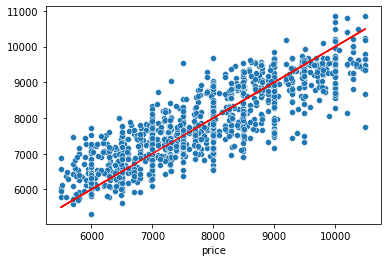

In [595]:
X_Aygo_nout = model_Aygo_no_outliers.drop('price', axis=1)
y_Aygo_nout = model_Aygo_no_outliers.price

X_Aygo_nout_train, X_Aygo_nout_test, y_Aygo_nout_train, y_Aygo_nout_test \
= split(X_Aygo_nout, y_Aygo_nout, test_size=0.3, random_state=124124)

lin_model_Aygo_no_outliers = LinearRegression().fit(X_Aygo_nout_train, y_Aygo_nout_train)

y_Aygo_nout_train_pred = lin_model_Aygo_no_outliers.predict(X_Aygo_nout_train)

print(f'RMSE = {mse(y_Aygo_nout_train, y_Aygo_nout_train_pred)**0.5} \
,prine mean= {model_Aygo_no_outliers.price.mean()}')

ax = sns.scatterplot(x=y_Aygo_nout_train, y=y_Aygo_nout_train_pred)
ax.plot(y_Aygo_nout_train, y_Aygo_nout_train, 'r')

### Mpg hyperparameter

In [532]:
#unique_Toyota.mpg.value_counts()
len(unique_Toyota.mpg.value_counts()) # 37

37

In [533]:
unique_Toyota.mpg.head()

0    36.2
1    36.2
2    36.2
3    36.2
4    36.2
Name: mpg, dtype: float64

In [534]:
unique_Toyota.describe()
unique_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6061 entries, 0 to 6632
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6061 non-null   object 
 1   price         6061 non-null   int64  
 2   transmission  6061 non-null   object 
 3   mileage       6061 non-null   int64  
 4   fuelType      6061 non-null   object 
 5   tax           6061 non-null   int64  
 6   mpg           6061 non-null   float64
 7   engineSize    6061 non-null   float64
 8   car_group     6061 non-null   object 
 9   car_age       6061 non-null   int64  
 10  mpg_group     6061 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 728.2+ KB


In [535]:
#df['A'] = df['A'].div(100).round(2)
#df['A'] = (df['A'] / 100).round(2)
#unique_Toyota['mpg_group'] = unique_Toyota.mpg.div(10).round(0)#.value_counts()
unique_Toyota['mpg_group'] = ((unique_Toyota['mpg'] /10).round(0))*10 #.value_counts()

In [536]:
unique_Toyota.mpg_group.value_counts()

70.0    2216
60.0    1908
50.0     692
80.0     650
90.0     318
40.0     277
Name: mpg_group, dtype: int64

In [537]:
#sns.jointplot(x='mpg_group', y='price', data=unique_Toyota, kind='reg', height=8)
unique_Toyota.groupby(['mpg_group','model']).size().sort_values(ascending=False)
unique_Toyota.groupby(['mpg_group'])['price'].agg('count').sort_values(ascending=False)

#unique_Toyota.groupby(['mpg_group'])['price'].agg({'price':['sum']}) #.sort_values(ascending=False)
# avg= 'mean', sum= 'sum'

#unique_Toyota.groupby(['mpg_group'])['price'].agg('price','sum') #.sort_values(ascending=False)

mpg_group
70.0    2216
60.0    1908
50.0     692
80.0     650
90.0     318
40.0     277
Name: price, dtype: int64

## Trees

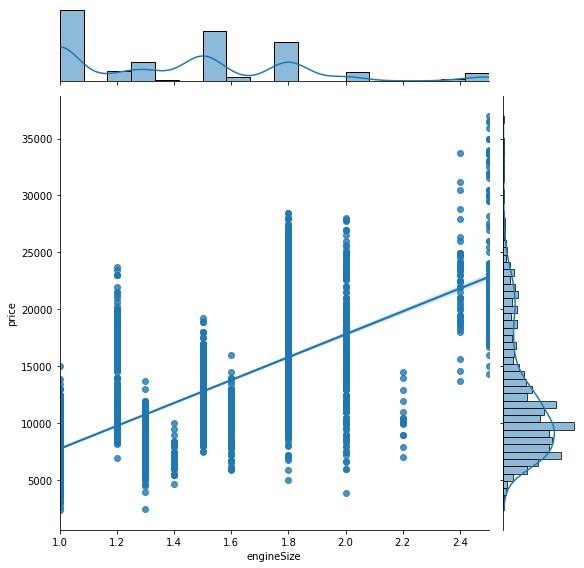

In [538]:
sns.jointplot(x='engineSize', y='price', data=dummies_Toyota, kind='reg', height=8)

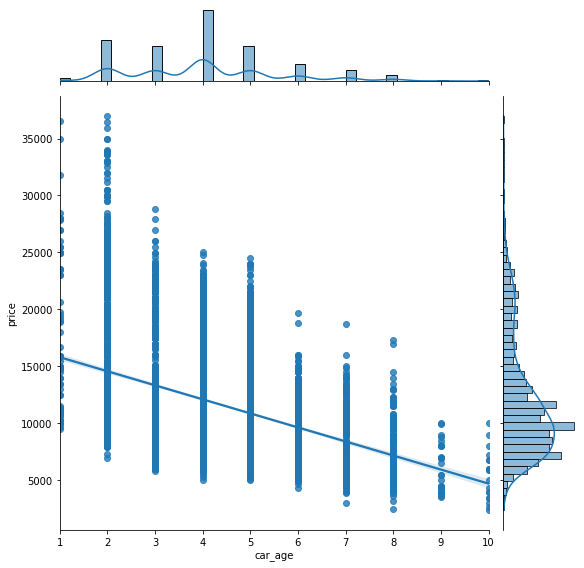

In [539]:
sns.jointplot(x='car_age', y='price', data=dummies_Toyota, kind='reg', height=8)

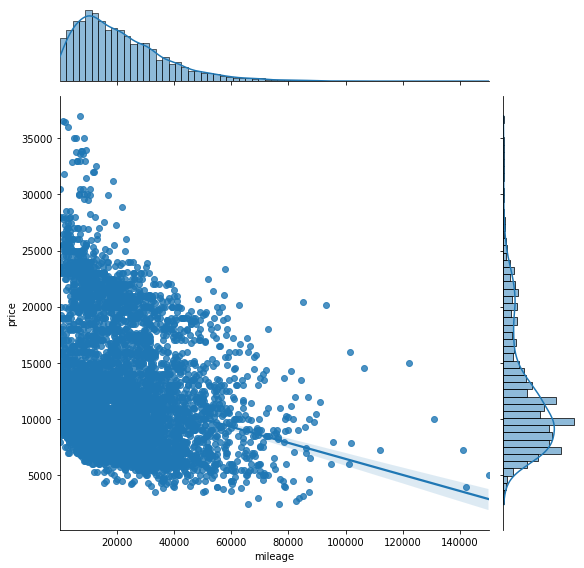

In [540]:
sns.jointplot(x='mileage', y='price', data=dummies_Toyota, kind='reg', height=8)

In [541]:
dummies_Toyota.columns

Index(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'mpg_group',
       'model_ Auris', 'model_ Avensis', 'model_ Aygo', 'model_ C-HR',
       'model_ Corolla', 'model_ GT86', 'model_ Hilux', 'model_ Prius',
       'model_ RAV4', 'model_ Verso', 'model_ Yaris', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol',
       'car_group_Family', 'car_group_Family - High End', 'car_group_SUV',
       'car_group_Small', 'car_group_Work and Sprot', 'mileage_per_year'],
      dtype='object')

### All Models

In [542]:
dummies_Toyota

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
0,16000,24089,265,36.2,2.0,5,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,48180.0
1,15995,18615,145,36.2,2.0,4,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,46540.0
2,13998,27469,265,36.2,2.0,6,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,45780.0
3,18998,14736,150,36.2,2.0,4,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,36840.0
4,17498,36284,145,36.2,2.0,4,40.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,90710.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,20630,8793,260,36.2,2.4,4,40.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,21980.0
6627,19350,20758,260,36.2,2.4,4,40.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,51900.0
6628,20388,85141,260,40.4,2.4,4,40.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,212850.0
6631,24995,17200,260,36.2,2.4,2,40.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,86000.0


In [543]:
X = dummies_Toyota.drop('price', axis=1)
y = dummies_Toyota.price

In [544]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=124124)

In [545]:
tree_model = DecisionTreeRegressor(max_leaf_nodes=50, min_samples_leaf=0.05)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=50,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.05, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

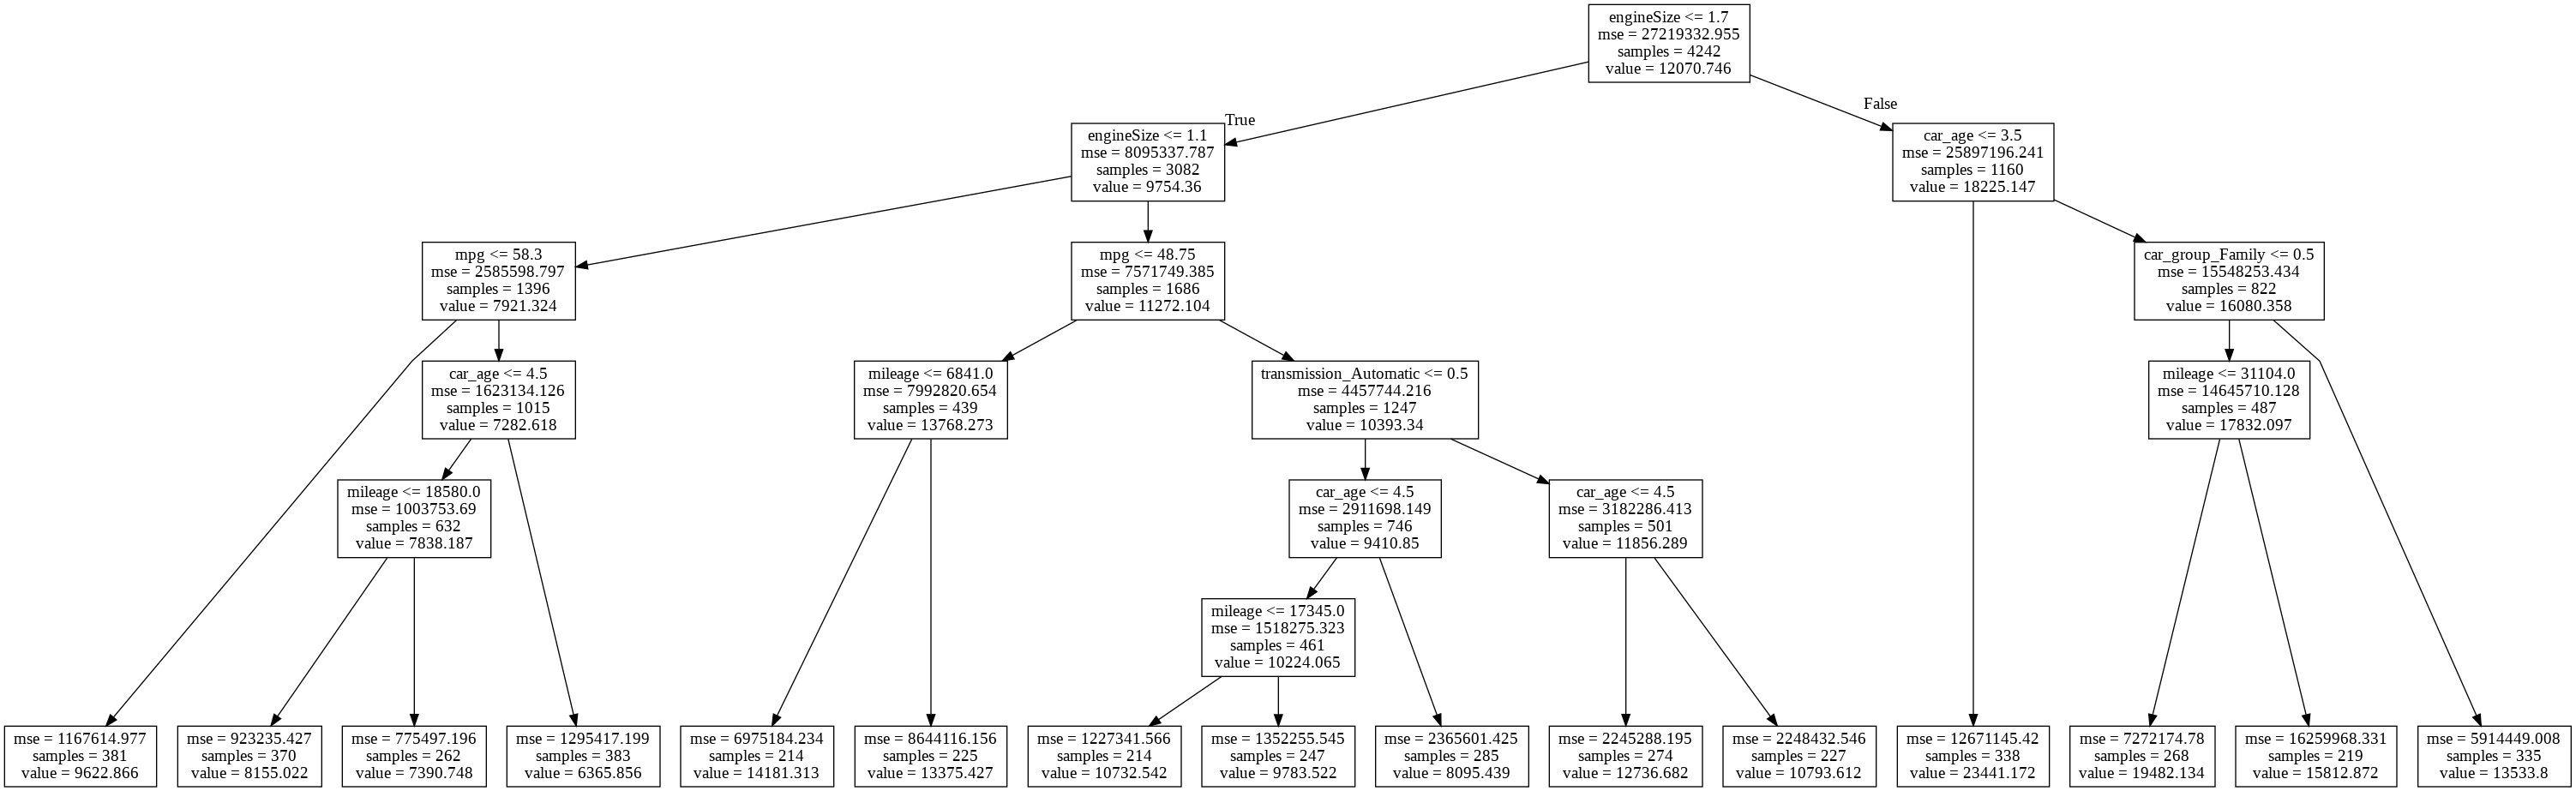

In [546]:
dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 

In [547]:
y_train_pred = tree_model.predict(X_train)

In [548]:
# people_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {dummies_Toyota.price.mean()}')


RMSE = 2121.59371594987 ,prine mean= 12057.604025738327


In [549]:
for feature, importance in zip(X_train.columns, tree_model.feature_importances_):
    print(f'{feature:12}: {importance}')

mileage     : 0.01957735504684323
tax         : 0.0
mpg         : 0.054118928186008414
engineSize  : 0.7164869379466575
car_age     : 0.1531685476897151
mpg_group   : 0.0
model_ Auris: 0.0
model_ Avensis: 0.0
model_ Aygo : 0.0
model_ C-HR : 0.0
model_ Corolla: 0.0
model_ GT86 : 0.0
model_ Hilux: 0.0
model_ Prius: 0.0
model_ RAV4 : 0.0
model_ Verso: 0.0
model_ Yaris: 0.0
transmission_Automatic: 0.018598584726689404
transmission_Manual: 0.0
transmission_Semi-Auto: 0.0
fuelType_Diesel: 0.0
fuelType_Hybrid: 0.0
fuelType_Other: 0.0
fuelType_Petrol: 0.0
car_group_Family: 0.03804964640408641
car_group_Family - High End: 0.0
car_group_SUV: 0.0
car_group_Small: 0.0
car_group_Work and Sprot: 0.0
mileage_per_year: 0.0


### check different values max_leaf_nodes 

5227.630540801886
5175.5108470391915


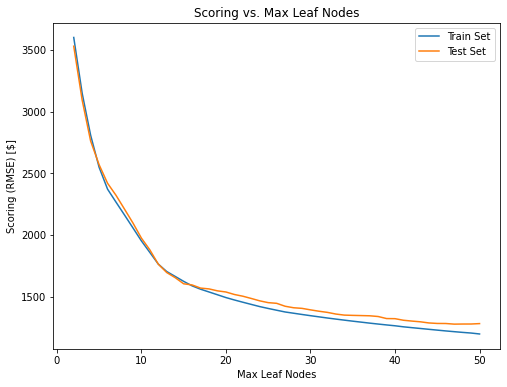

In [550]:
#<! Showing the ability of Decision Trees to Overfit

vMaxLeafNodes = range(2, 51)
XTrain, XTest, yTrain, yTest = split(X_train, y_train, train_size=0.8, random_state=124124)
vTrainRmse = np.zeros(len(vMaxLeafNodes))
vTestRmse = np.zeros(len(vMaxLeafNodes))

#<! This is basically a basic procedure to look after an optimal hyper parameter
for ii in range(len(vMaxLeafNodes)):
  modelTree = DecisionTreeRegressor(max_leaf_nodes=vMaxLeafNodes[ii])
  modelTree.fit(X_train, y_train)
  vTrainRmse[ii] = mse(modelTree.predict(X_train), y_train, squared=False)
  vTestRmse[ii] = mse(modelTree.predict(X_test), y_test, squared=False)

hF, hA = plt.subplots(figsize=(8, 6))
hA.plot(vMaxLeafNodes, vTrainRmse, label='Train Set')
hA.plot(vMaxLeafNodes, vTestRmse, label='Test Set')
hA.set_xlabel('Max Leaf Nodes')
hA.set_ylabel('Scoring (RMSE) [$]')
hA.set_title('Scoring vs. Max Leaf Nodes')
plt.legend()

#<! For Reference (Check against the elementary thing to do - Mean)
print(np.sqrt(np.mean(np.square(yTrain - np.mean(yTrain)))))
print(np.sqrt(np.mean(np.square(yTest - np.mean(yTrain)))))


### Tree for Yaris Only

In [551]:
model_Yaris = dummies_Toyota.loc[dummies_Toyota['model_ Yaris'] == 1]
model_Yaris.head()

,price,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
813,14000,6821,150,47.9,1.5,2,50.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,34100.0
814,10750,14000,145,58.9,1.5,3,60.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,46670.0
815,11500,31911,0,78.0,1.5,5,80.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,63820.0
816,8500,72053,0,76.3,1.5,7,80.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,102930.0
817,8750,32594,150,58.9,1.5,4,60.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,81480.0


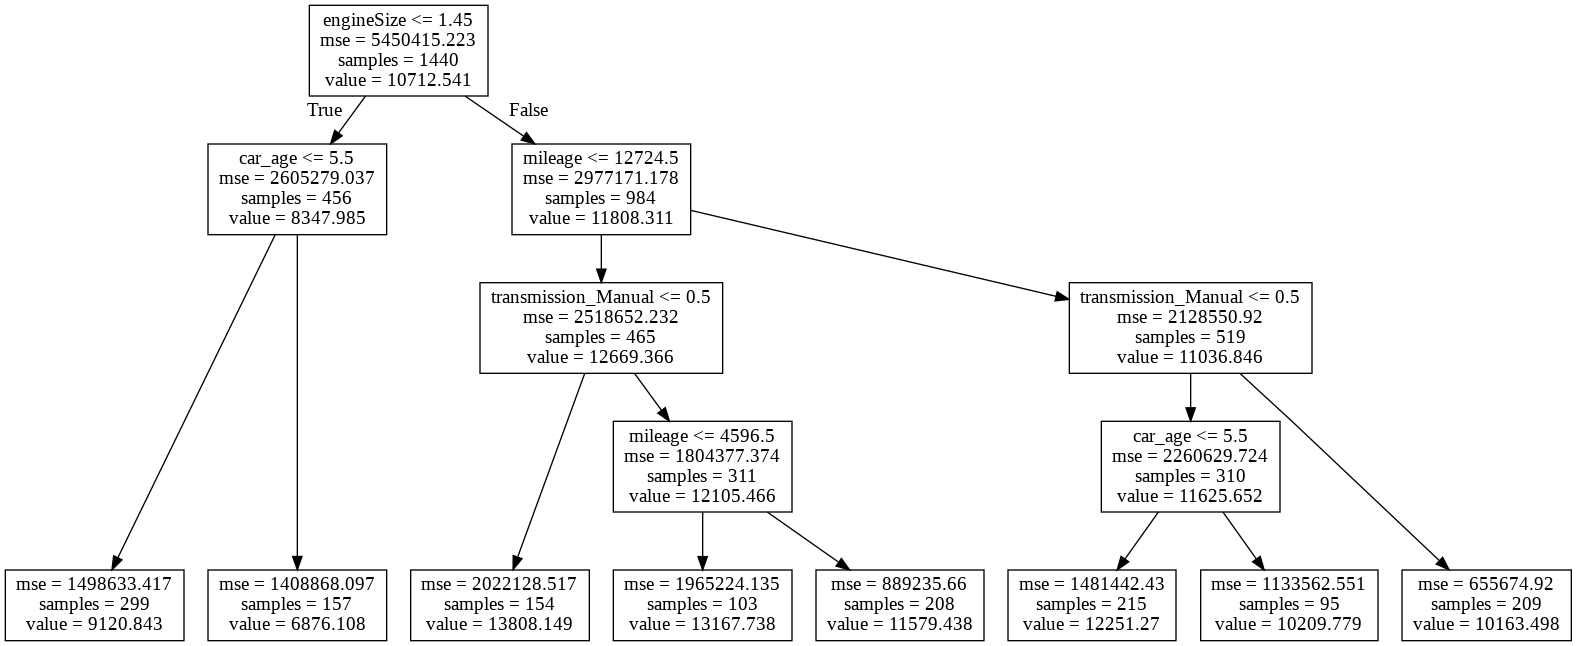

In [552]:
X = model_Yaris.drop('price', axis=1)
y = model_Yaris.price

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=124124)

tree_model = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=0.05)
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)

dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 


In [553]:
y_train_pred = tree_model.predict(X_train)

# people_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {model_Yaris.price.mean()}')

RMSE = 1158.0950595476907 ,prine mean= 10718.067541302235


### Tree for Yaris no Outlier

In [554]:
q_low = model_Yaris["price"].quantile(0.05)
q_hi  = model_Yaris["price"].quantile(0.95)

print(f'prine mean={model_Yaris.price.mean()}, q_low= {q_low}, q_hi={q_hi}')

model_Yaris_no_outliers = model_Yaris[(model_Yaris["price"] < q_hi) & (model_Yaris["price"] > q_low)]

prine mean=10718.067541302235, q_low= 6669.900000000001, q_hi=14306.09999999999


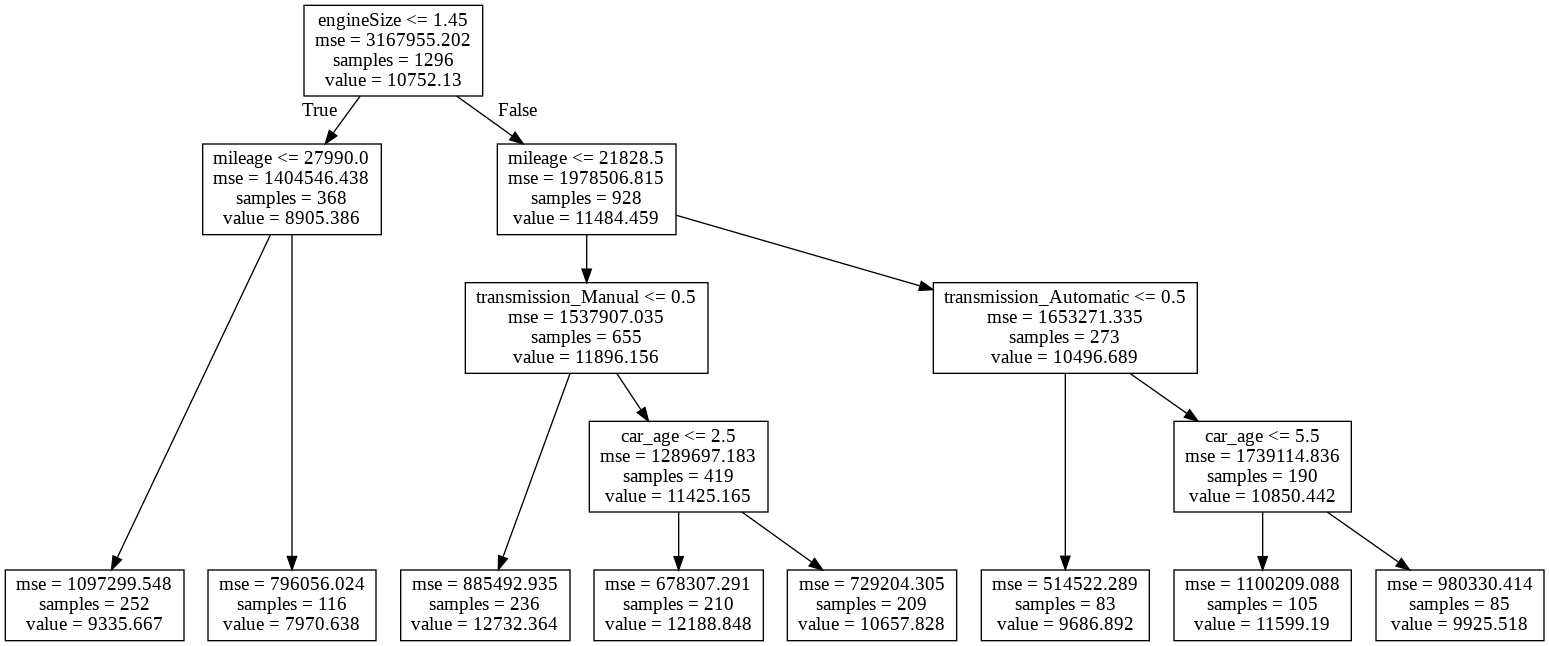

In [555]:
X = model_Yaris_no_outliers.drop('price', axis=1)
y = model_Yaris_no_outliers.price

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=124124)

tree_model = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=0.05)
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)

dot_data = StringIO()  
export_graphviz(tree_model, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 


In [556]:
y_train_pred = tree_model.predict(X_train)

# people_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE = {mse(y_train, y_train_pred)**0.5} ,prine mean= {model_Yaris_no_outliers.price.mean()}')

RMSE = 927.2295194003664 ,prine mean= 10722.917926565875


# K-Nearest Neighbors

## First Shot

In [557]:
neighbor = 9

In [558]:
X_train.head(5)

,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
2382,9133,145,47.9,1.5,2,50.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,45660.0
2018,36111,0,86.0,1.5,6,90.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,60180.0
1168,23003,30,55.0,1.3,4,60.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,57510.0
2267,10571,145,60.1,1.5,3,60.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,35240.0
2358,12805,30,58.0,1.3,5,60.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,25610.0


In [559]:
knn_model_1 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train, y_train)

In [560]:
y_train_pred = knn_model_1.predict(X_train)

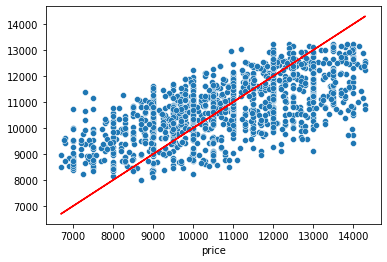

In [561]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [562]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

1341.3811487428025

### Validating the Model

In [563]:
y_test_pred = knn_model_1.predict(X_test)

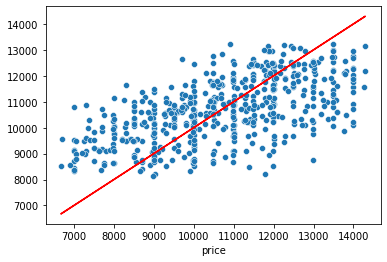

In [564]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [565]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

1455.403032416156

## Scaling the Data

In [566]:
X_train.head()

,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
2382,9133,145,47.9,1.5,2,50.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,45660.0
2018,36111,0,86.0,1.5,6,90.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,60180.0
1168,23003,30,55.0,1.3,4,60.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,57510.0
2267,10571,145,60.1,1.5,3,60.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,35240.0
2358,12805,30,58.0,1.3,5,60.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,25610.0


In [567]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,mileage,tax,mpg,engineSize,car_age,mpg_group,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,model_ Corolla,model_ GT86,model_ Hilux,model_ Prius,model_ RAV4,model_ Verso,model_ Yaris,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_group_Family,car_group_Family - High End,car_group_SUV,car_group_Small,car_group_Work and Sprot,mileage_per_year
0,0.109656,0.966667,0.556977,1.000000,0.222222,0.555556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.173322
1,0.433568,0.000000,1.000000,1.000000,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.228439
2,0.276186,0.200000,0.639535,0.866667,0.444444,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.218304
3,0.126921,0.966667,0.698837,1.000000,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.133769
4,0.153744,0.200000,0.674419,0.866667,0.555556,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.097214


## Second Model

In [568]:
knn_model_2 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train_scaled, y_train)

In [569]:
y_train_pred = knn_model_2.predict(X_train_scaled)

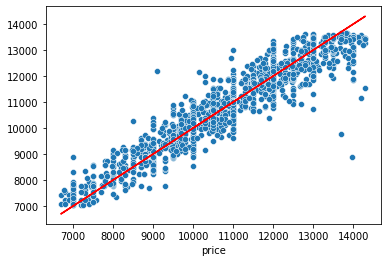

In [570]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [571]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

615.4096584207664

### Validating the Model

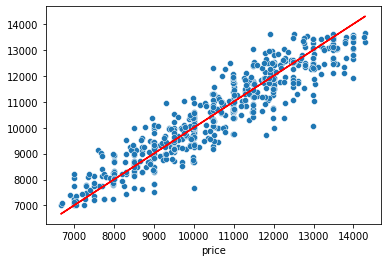

In [572]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [573]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

668.4070268875705

## Different K for knn maxabs scaled model

# Meging all Regression models